In [1]:
from pyscf import gto, dft, scf, lib, cc, fci
import numpy as np
import scipy as sp

Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


<IPython.core.display.Javascript object>


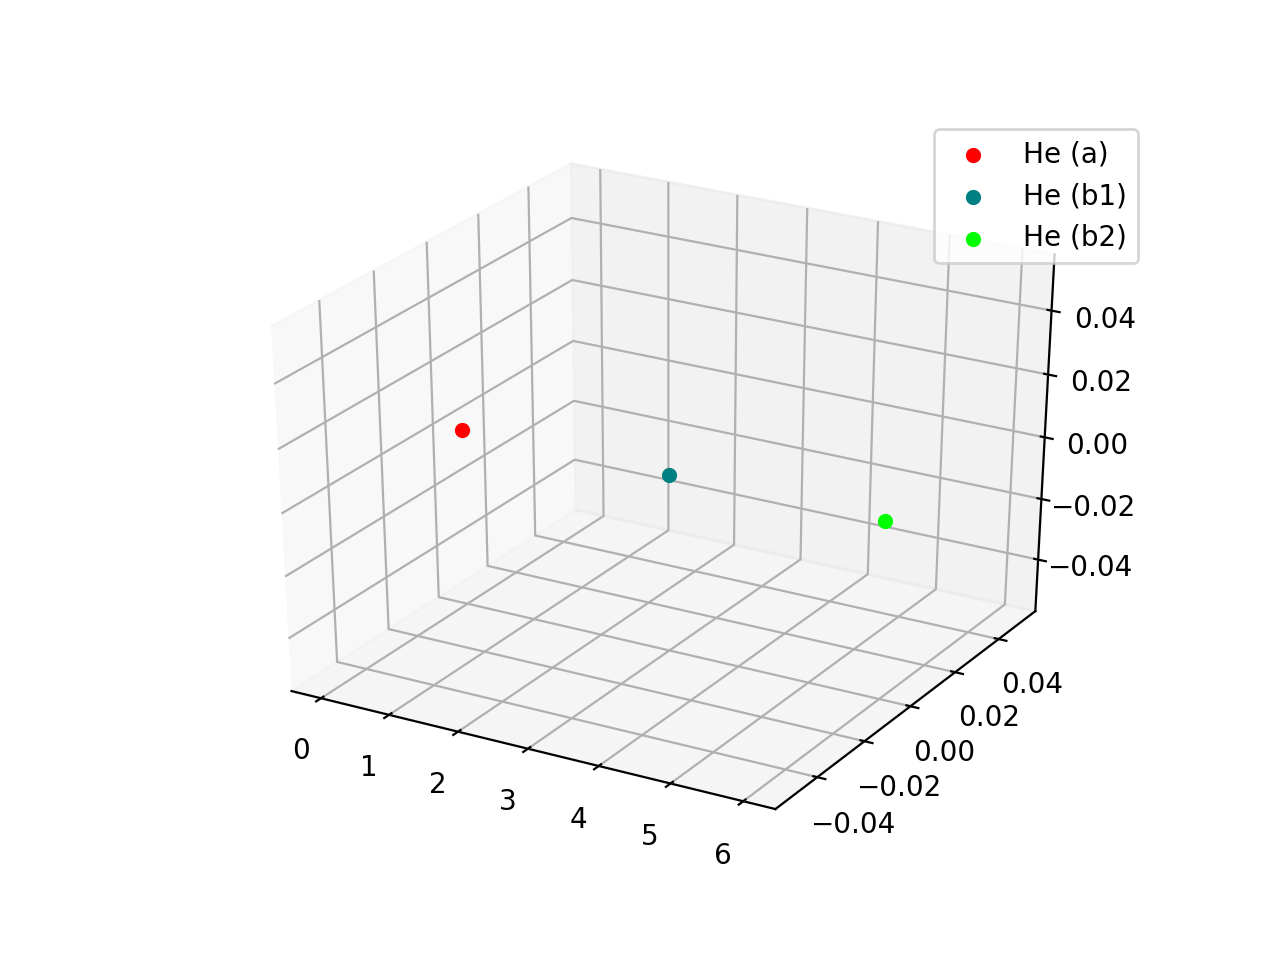

In [2]:
# uses definitions from:  Chemical Physics Letters 248 (1996) 71-76
%matplotlib notebook

He_a=(0, 0, 0)
He_b1= (3, 0, 0)
He_b2= (6,0,0)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*He_a, marker='o', color='red', label='He (a)')
ax.scatter(*He_b1, marker='o', color='teal', label='He (b1)')
ax.scatter(*He_b2, marker='o', color='lime', label='He (b2)')
plt.legend()
plt.show()


In [ ]:
He_a=(0, 0, 0)
He_b1= (3, 0, 0)
He_b2= (6,0,0)

In [14]:
# basis = {'O': 'sto-3g', 'H': 'cc-pvdz', 'H@2': '6-31G'}
S_A = gto.Mole(atom='{} {} {} {}'.format('He',*He_a),
               basis={'He': 'sto-3g'},
               charge=0,
               spin=0)

print(S_A.atom)
print('')
S_A.build()

He 0 0 0



In [19]:
S_B = gto.Mole(atom='{} {} {} {}'.format('He',*He_b1) + "; " + '{} {} {} {}'.format('He',*He_b2),
               basis={'He': 'sto-3g', 'He': 'sto-3g'},
               charge=0,
               spin=0)

print(S_B.atom)
print('')
S_B.build()

He 3 0 0; He 6 0 0



In [20]:
S_A.basis.copy()

{'He': 'sto-3g'}

In [25]:
mC.basis

{'He': 'sto-3g'}

In [102]:
# generate supermolecule

mC = gto.Mole()
atmC = []

# copy all atoms from mole A
for i in range(S_A.natm):
    atmC.append([S_A.atom_symbol(i), S_A.atom_coord(i)])
mC.basis = S_A.basis.copy()

# copy all atoms from mole B
for i in range(S_B.natm):
    atmC.append([S_B.atom_symbol(i), S_B.atom_coord(i)])
    mC.basis.update({S_B.atom_symbol(i): S_B.basis[S_B.atom_symbol(i)]})

mC.atom = atmC
mC.verbose = S_A.verbose
mC.charge = S_A.charge + S_B.charge
mC.unit = "bohr"#"angstrom" # "bohr" #  # atom_coord is always stored in bohr (?)
mC.build(dump_input=False)

mC.atom

[['He', array([0., 0., 0.])],
 ['He', array([5.66917837, 0.        , 0.        ])],
 ['He', array([11.33835675,  0.        ,  0.        ])]]

In [47]:
# generate grid by concatenating subsystems
smol = mC #supermolecule!!!

# get grids
grids = dft.gen_grid.Grids(mC)
grids.level = 4 # set to 4 in the input file! 
grids.build()

In [48]:
# Total number of contracted GTOs = nao_nr
sna = smol.nao_nr() # supersystem

na = [S_A.nao_nr(), S_B.nao_nr()] # each subsytem

In [82]:

def get_scf(mol, grids, emded_dft=False, embed_xc=None, conv_tol=1e-10, grad=1e-8, maxiter=300):
    """Perform SCF on an individual subsystem."""

    # get pySCF SCF object
    if emded_dft:
        mSCF = scf.RKS(mol)
        mSCF.xc = embed_xc
        mSCF.small_rho_cutoff = 1e-20
    else:
        mSCF = scf.RHF(mol)

    # set some defaults
    mSCF.diis = True
    mSCF.grids = grids
    mSCF.init_guess = "atom"
#     mSCF.damp = inp.damp
#     mSCF.level_shift = inp.shift

#     if inp.memory is not None:
#         mSCF.max_memory = inp.memory

    # set some other defaults
    mSCF.conv_tol = conv_tol
    mSCF.conv_tol_grad = grad
    mSCF.max_cycle = maxiter
    
    # return object
    return mSCF

In [56]:
# Initialize 1e matrices from supermolecular system.

# get subsystem overlap integrals
sSCF = get_scf(smol, grids)
Hcore = sSCF.get_hcore()
Smat = sSCF.get_ovlp()
Fock = np.zeros((sna, sna))


In [83]:
# subsystem
nsub=2 # number of subsystems

mSCF = [None for _ in range(nsub)]

sub_systems = [S_A, S_B]
for index, subsystem in enumerate(sub_systems):
    mSCF[index] = get_scf(subsystem, grids)

In [57]:
Dmat = [None for _ in range(nsub)]
for j in range(nsub):
    Dmat[j] = mSCF[j].init_guess_by_atom()

In [59]:
np.array([0,1]).shape[0]

2

In [110]:
def get_sub2sup(mSCF, S_A, S_B):

    nao = np.array([mSCF[0].mol.nao_nr(), mSCF[1].mol.nao_nr()])
    nssl = [None for _ in range(nao.shape[0])]
    for i in range(nao.shape[0]):
        nssl[i] = np.zeros(mSCF[i].mol.natm, dtype=int)
        for j in range(mSCF[i].mol.natm):
            ib = np.where(mSCF[i].mol._bas.transpose()[0] == j)[0].min()
            ie = np.where(mSCF[i].mol._bas.transpose()[0] == j)[0].max()
            ir = mSCF[i].mol.nao_nr_range(ib, ie + 1)
            ir = ir[1] - ir[0]
            nssl[i][j] = ir

        if nssl[i].sum() != mSCF[i].mol.nao_nr():
            print("ERROR: naos not equal!")

###     mAB = concatenate_mols(mSCF[0].mol, mSCF[1].mol, ghost=False)
    mAB = gto.Mole()
    atmC = []

    # copy all atoms from mole A
    for i in range(S_A.natm):
        atmC.append([S_A.atom_symbol(i), S_A.atom_coord(i)])
    mAB.basis = S_A.basis.copy()

    # copy all atoms from mole B
    for i in range(S_B.natm):
        atmC.append([S_B.atom_symbol(i), S_B.atom_coord(i)])
        mAB.basis.update({S_B.atom_symbol(i): S_B.basis[S_B.atom_symbol(i)]})

    mAB.atom = atmC
    mAB.verbose = S_A.verbose
    mAB.charge = S_A.charge + S_B.charge
    mAB.unit = "bohr" #"angstrom" #  # atom_coord is always stored in bohr (?)
    mAB.build(dump_input=False)
    #####

    nT = mAB.nao_nr()
    nsl = np.zeros(mAB.natm, dtype=int)
    for i in range(mAB.natm):
        ib = np.where(mAB._bas.transpose()[0] == i)[0].min()
        ie = np.where(mAB._bas.transpose()[0] == i)[0].max()
        ir = mAB.nao_nr_range(ib, ie + 1)
        ir = ir[1] - ir[0]
        nsl[i] = ir

    if nsl.sum() != mAB.nao_nr():
        print("ERROR: naos not equal!")
    sub2sup = [None for _ in range(nao.shape[0])]
    for i in range(nao.shape[0]):
        sub2sup[i] = np.zeros(nao[i], dtype=int)
        for a in range(mSCF[i].mol.natm):
            match = False
            for b in range(mAB.natm):
                # distance between two vectors! 
                d= np.dot(mSCF[i].mol.atom_coord(a) - mAB.atom_coord(b), mSCF[i].mol.atom_coord(a) - mAB.atom_coord(b))
                if d < 0.001:
                    match = True
                    ia = nssl[i][0:a].sum()
                    ja = ia + nssl[i][a]
                    ib = nsl[0:b].sum()
                    jb = ib + nsl[b]
                    sub2sup[i][ia:ja] = range(ib, jb)

            if not match:
                print("ERROR: I did not find an atom match!")

    return sub2sup

In [107]:
aa= get_sub2sup(mSCF, S_A, S_B)

[array([0]), array([1, 2])]